In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('ggplot')

# DATA ACQUISITION

In [2]:
df = pd.read_csv('Proveindustriales_Data_Cleaned_Kprototipe_csv.csv')

In [3]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'SUBCATEGORÍA',
       'PROVEEDOR', 'PRESUPUESTO', 'COMPAÑÍA_COMPRADORA', 'ESTADO',
       'PRODUCTO_O_SERVICIO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'PRECIO_UNITARIO_+_IVA', 'IVA', 'TOTAL_SIN_IVA',
       'TOTAL_+_IVA', 'FECHA_ÚLTIMO_MOVIMIENTO', 'DURACIÓN_ENTREGA',
       'DURACIÓN_APROBACIÓN'],
      dtype='object')

In [4]:
df.sample(2)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,SUBCATEGORÍA,PROVEEDOR,PRESUPUESTO,COMPAÑÍA_COMPRADORA,ESTADO,PRODUCTO_O_SERVICIO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,PRECIO_UNITARIO_+_IVA,IVA,TOTAL_SIN_IVA,TOTAL_+_IVA,FECHA_ÚLTIMO_MOVIMIENTO,DURACIÓN_ENTREGA,DURACIÓN_APROBACIÓN
13734,38000,932,Vigilancia y seguridad industrial,Seguridad y protección personal,Proveedor 301,Presupuesto 868,Portal comprador 24,Recibido,85 Overol industrial,10.000,10.000,62222.000,74044.000,11822,622218.000,740440.000,2020-02-13,0.000,20.000
723,49268,22,Dotación y elementos de protección personal,Camisas y camisetas,Proveedor 29,Presupuesto 711,Portal comprador 6,Orden en Proceso,CAMISA COMERCIAL GRANEL -COND CISTERNA-COND TR...,6.000,0.000,37900.000,45101.000,7201,227400.000,270606.000,2021-10-28,42.000,6.000


## IRRELEVANT COLUMNS

In [5]:
cols_to_drop = ['FECHA_ÚLTIMO_MOVIMIENTO','DURACIÓN_ENTREGA', 'DURACIÓN_APROBACIÓN', 'PRECIO_UNITARIO_+_IVA', 'TOTAL_+_IVA', 'PRESUPUESTO', 'SUBCATEGORÍA', 'PRODUCTO_O_SERVICIO', 'NÚMERO_PEDIDO', 'ORDEN_NÚMERO']

In [6]:
df.drop(cols_to_drop, inplace=True, axis=1)

## DF ORIGINAL

In [7]:
df.head(3)

,CATEGORÍA,PROVEEDOR,COMPAÑÍA_COMPRADORA,ESTADO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,Eléctricos y Electrónicos,Proveedor 1,Portal comprador 1,Orden en Proceso,2.000,0.000,23364.000,4439,46728.000
1,Mercadeo y publicidad,Proveedor 2,Portal comprador 1,Recibido,1.000,1.000,1476972.000,280625,1476972.000
2,Alimentos y Bebidas,Proveedor 3,Portal comprador 1,Orden en Proceso,10.000,0.000,15500.000,0,155000.000


In [8]:
df.columns

Index(['CATEGORÍA', 'PROVEEDOR', 'COMPAÑÍA_COMPRADORA', 'ESTADO',
       'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA', 'PRECIO_UNITARIO', 'IVA',
       'TOTAL_SIN_IVA'],
      dtype='object')

## CHECK INSA()

In [9]:
df.isna().sum()

CATEGORÍA              0
PROVEEDOR              0
COMPAÑÍA_COMPRADORA    0
ESTADO                 0
CANTIDAD_PEDIDA        0
CANTIDAD_RECIBIDA      0
PRECIO_UNITARIO        0
IVA                    0
TOTAL_SIN_IVA          0
dtype: int64

In [10]:
df.select_dtypes('object').nunique()

CATEGORÍA               36
PROVEEDOR              405
COMPAÑÍA_COMPRADORA     33
ESTADO                   9
dtype: int64

## DISTRIBUTION OF ALL "CATEGORÍA"

In [11]:
df_CATEGORIA = pd.DataFrame(df['CATEGORÍA'].value_counts()).reset_index()

In [12]:
df_CATEGORIA['Percentage'] = df_CATEGORIA['CATEGORÍA'] / df['CATEGORÍA'].value_counts().sum()

In [13]:
df_CATEGORIA.rename(columns = {'index':'CATEGORÍA', 'CATEGORÍA':'Total'}, inplace = True)


## CREATE THE DATAFRAME OF "CATEGORIA"

In [14]:
df_CATEGORIA.head(2)

,CATEGORÍA,Total,Percentage
0,Alimentos y Bebidas,6938,0.310
1,Vigilancia y seguridad industrial,6049,0.270


### Sort values by TOTAL

In [15]:
df_CATEGORIA = df_CATEGORIA.sort_values('Total', ascending = True).reset_index(drop = True)

In [16]:
df.columns

Index(['CATEGORÍA', 'PROVEEDOR', 'COMPAÑÍA_COMPRADORA', 'ESTADO',
       'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA', 'PRECIO_UNITARIO', 'IVA',
       'TOTAL_SIN_IVA'],
      dtype='object')

## GROUP BY CATEGORIA

In [17]:
# The dataframe
df_CATEGORIA = df.groupby('CATEGORÍA').agg({
    'CATEGORÍA': 'count',
    'CANTIDAD_PEDIDA': 'sum',
    'CANTIDAD_RECIBIDA': 'sum',
    'PRECIO_UNITARIO': 'mean',
    'IVA': 'sum',
    'TOTAL_SIN_IVA': 'sum'
    }
).rename(columns = {'CATEGORÍA': 'Total'}).reset_index().sort_values('Total', ascending = True)

In [18]:
df_CATEGORIA.sort_values(by='Total', ascending=False).head(2)

,CATEGORÍA,Total,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
1,Alimentos y Bebidas,6938,2763255.730,85211.760,15358.184,13873146,1928684546.000
35,Vigilancia y seguridad industrial,6049,234476.000,233765.000,38586.506,44227525,4339572473.000


## CROSS TAB "CATEGORY"

In [19]:
order_CATEGORIA = df_CATEGORIA['CATEGORÍA'].to_list()

In [20]:
order_CATEGORIA.append('All')

In [21]:
(pd.crosstab(df['CATEGORÍA'], df['TOTAL_SIN_IVA'], margins = True).reindex(order_CATEGORIA, axis = 0).reset_index()).sort_values(by='All', ascending='True').head(7)

TOTAL_SIN_IVA,CATEGORÍA,0.0,1.0,16.0,22.0,84.0,93.0,96.0,100.0,110.0,...,46218484.0,54226464.0,56782170.0,73220000.0,80672270.0,86786424.0,87840000.0,241765920.0,299185300.0,All
0,Producción audiovisual,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Educación y formación empresarial,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Gestión inmobiliaria,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
3,Agroindustrial,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,Minería,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5,Generación y distribución de Energía,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,Servicios Públicos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [22]:
df_CATEGORIA = pd.crosstab(df['CATEGORÍA'], df['TOTAL_SIN_IVA'], margins = True).reindex(order_CATEGORIA, axis = 0).reset_index()

In [23]:
# Remove index name
df_CATEGORIA.columns.name = None
df_CATEGORIA.head(3)

,CATEGORÍA,0.0,1.0,16.0,22.0,84.0,93.0,96.0,100.0,110.0,...,46218484.0,54226464.0,56782170.0,73220000.0,80672270.0,86786424.0,87840000.0,241765920.0,299185300.0,All
0,Producción audiovisual,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Educación y formación empresarial,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Gestión inmobiliaria,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4


## GET POSITION OF CATEGORICAL COLS

In [24]:
df_CATEGORIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Columns: 6283 entries, CATEGORÍA to All
dtypes: int64(6282), object(1)
memory usage: 1.8+ MB


In [25]:
[df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

[0, 1, 2, 3]

In [26]:
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

In [27]:
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['CATEGORÍA', 'PROVEEDOR', 'COMPAÑÍA_COMPRADORA', 'ESTADO']
Categorical columns position  : [0, 1, 2, 3]


## CONVERT DF TO MATRIX WITH NUMPY

In [28]:
dfMatrix = df.to_numpy()
dfMatrix

array([['Eléctricos y Electrónicos', 'Proveedor 1', 'Portal comprador 1',
        ..., 23364.0, 4439, 46728.0],
       ['Mercadeo y publicidad', 'Proveedor 2', 'Portal comprador 1',
        ..., 1476972.0, 280625, 1476972.0],
       ['Alimentos y Bebidas', 'Proveedor 3', 'Portal comprador 1', ...,
        15500.0, 0, 155000.0],
       ...,
       ['Moda y accesorios', 'Proveedor 229', 'Portal comprador 8', ...,
        29412.0, 5588, 88235.0],
       ['Moda y accesorios', 'Proveedor 229', 'Portal comprador 8', ...,
        29412.0, 5588, 117647.0],
       ['Aseo, Cafetería y Oficina', 'Proveedor 229',
        'Portal comprador 8', ..., 33613.0, 6387, 168067.0]], dtype=object)

## OPTIMAL K USING ELBOW METHOD

In [29]:
cost = []
for cluster in range(2, 8):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


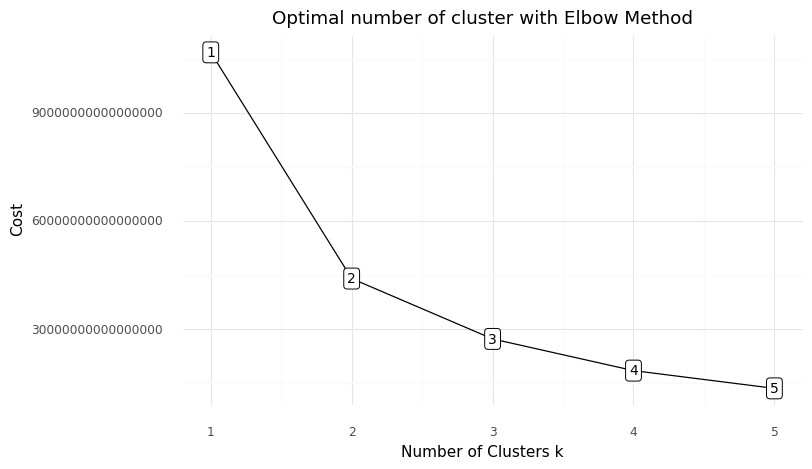

<ggplot: (132747988818)>

In [30]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

## FTI MODEL WITH K CLUSTER

In [29]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

### CENTROIDS

In [30]:
# Cluster centorid
kprototype.cluster_centroids_

array([['196.6388202447958', '49.44693379790941', '70171.90896095773',
        '11119.092021799339', '438847.03658536583',
        'Alimentos y Bebidas', 'Proveedor 301', 'Portal comprador 1',
        'Recibido'],
       ['348.5', '333.66666666665697', '14637658.5',
        '1431559.8333333333', '144911652.33333334',
        'Construcción y Mantenimiento', 'Proveedor 20',
        'Portal comprador 1', 'Orden en Proceso']], dtype='<U32')

N_ITER

In [31]:

# Check the iteration of the clusters created
kprototype.n_iter_

8

### COST_

In [32]:

# Check the cost of the clusters created
kprototype.cost_

1.0673260621586027e+17

## ADD THE CLUSTER TO THE DF

In [33]:
len(kprototype.labels_)

22392

In [35]:
df['Cluster Labels'] = kprototype.labels_
df['Segment'] = df['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})

In [37]:
df.sample(5)

,CATEGORÍA,PROVEEDOR,COMPAÑÍA_COMPRADORA,ESTADO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA,Cluster Labels,Segment
21333,Alimentos y Bebidas,Proveedor 322,Portal comprador 29,Orden en Proceso,120.000,0.000,745.000,141,89345.000,2,Third
6285,Alimentos y Bebidas,Proveedor 65,Portal comprador 2,Cancelado,1.000,0.000,18067.000,3433,18067.000,2,Third
4716,"Aseo, Cafetería y Oficina",Proveedor 28,Portal comprador 1,Recibido,3.000,3.000,8235.000,1565,24705.000,2,Third
11872,Alimentos y Bebidas,Proveedor 24,Portal comprador 2,Recibido,1.000,1.000,106378.000,20212,106378.000,2,Third
16426,Vigilancia y seguridad industrial,Proveedor 301,Portal comprador 24,Recibido,28.000,28.000,31092.000,5908,870588.000,2,Third


## ORDER CLUSTER

In [38]:
# Order the cluster
df['Segment'] = df['Segment'].astype('category')
df['Segment'] = df['Segment'].cat.reorder_categories(list(df["Segment"].unique()))

## CLUSTER INTERPRETATION

In [39]:
# Cluster interpretation
df.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df.groupby('Segment').agg(
    {
        #'Total':'count',
        'COMPAÑÍA_COMPRADORA': lambda x: x.value_counts().index[0],
        'CATEGORÍA':lambda x: x.value_counts().index[0],
        'CANTIDAD_PEDIDA': 'sum',
        'CANTIDAD_RECIBIDA': 'sum',
        'PRECIO_UNITARIO': 'mean',
        'IVA': 'sum',
        'TOTAL_SIN_IVA': 'sum'
    }
).reset_index()

,Segment,COMPAÑÍA_COMPRADORA,CATEGORÍA,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,Third,Portal comprador 1,Alimentos y Bebidas,4390680.630,1096293.060,60042.934,215386701,9115381779.000
1,First,Portal comprador 1,Construcción y Mantenimiento,13350.000,12628.000,9351504.037,35798517,1037166676.000
2,Second,Portal comprador 1,Construcción y Mantenimiento,17.000,0.000,31731777.000,6316135,540951220.000


In [40]:
df.groupby('Segment')['Segment'].count()

Segment
Third     22363
First        27
Second        2
Name: Segment, dtype: int64

In [36]:
df.to_csv('Kprototype_clusters_2_Categoria.csv', index=False)

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (1.01% inertia)', ylabel='Component 1 (0.77% inertia)'>

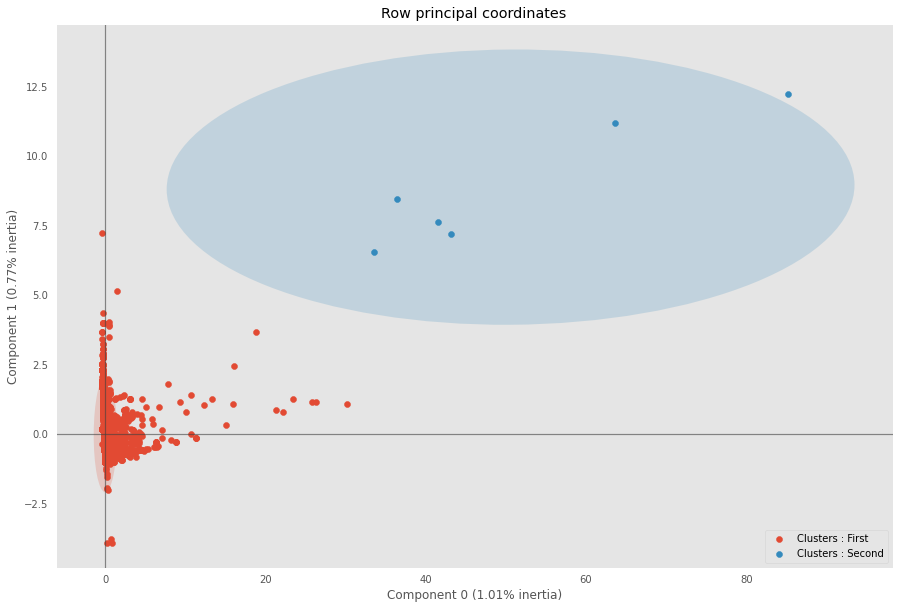

In [37]:
from prince import FAMD

X=pd.read_csv("Kprototype_clusters_2_Categoria.csv")

famd = FAMD(n_components =2, n_iter = 3, random_state = 101)

famd.fit(X)
famd.transform(X)
famd.plot_row_coordinates(X,figsize=(15, 10),color_labels=['Clusters : {}'.format(t) for t in X['Segment']] )